<a href="https://colab.research.google.com/github/IvanIsCoding/GNN-for-Combinatorial-Optimization/blob/main/01_GNN_vs_SA_for_Max_Cut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is where we compare Graph Neural Networks vs Simulated Annealing

https://arxiv.org/abs/2206.13211

In [17]:
!pip install -q git+https://github.com/IvanIsCoding/GNN-for-Combinatorial-Optimization.git

  Preparing metadata (setup.py) ... done


We saw the definition of GNNs on the previous one, time to see what simulated annealing is about

In [18]:
from gnn_for_co.core import create_train_state, train_step, get_classification, create_Q_matrix, create_max_cut_model

import jax
import jax.numpy as jnp
import numpy as np
import networkx as nx
import openjij as oj
from tqdm.notebook import trange, tqdm

In [19]:
G = nx.convert_node_labels_to_integers(nx.fast_gnp_random_graph(n = 100, p=0.05, seed=2023))

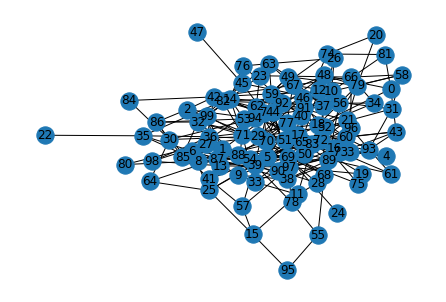

In [20]:
nx.draw(G, pos=nx.spring_layout(G, seed=2023), with_labels=True)

In [21]:
sampler = oj.SASampler()

In [22]:
model = create_max_cut_model(G)
qubo_dict, offset = model.to_qubo()

In [23]:
response = sampler.sample_qubo(qubo_dict, num_reads=1000)

In [24]:
response.first.energy

-213.0

In [25]:
node_color = ["lightblue" for i in range(G.number_of_nodes())]
for x, val in response.first.sample.items():
  if val == 1:
    node_color[int(x[2:-1])] = "yellow"

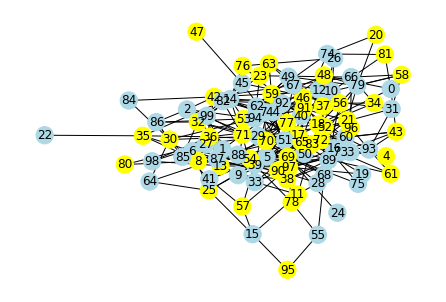

In [26]:
nx.draw(G, pos=nx.spring_layout(G, seed=2023), node_color=node_color, with_labels=True)

Notice that simulated annealing found a better solution. Time to 

In [27]:
def solve_with_gnn(G, embedding_size, hidden_size, learning_rate, epochs, dropout_rate, seed=2023, verbose=False):
  A = jnp.array(nx.to_numpy_array(G))
  Q = create_Q_matrix(G)

  rng = jax.random.PRNGKey(seed)
  rng, init_rng = jax.random.split(rng)
  rng, embed_rng = jax.random.split(rng)
  state = create_train_state(G.number_of_nodes(), embedding_size, hidden_size, init_rng, learning_rate, dropout_frac=0.01)
  node_embeddings = jax.random.uniform(embed_rng, [G.number_of_nodes(), embedding_d0])

  for epoch in trange(1, epochs + 1, disable=not verbose):
    rng, dropout_rng = jax.random.split(rng)
    state, metrics = train_step(state=state, node_embeddings=node_embeddings, adj_matrix=A, q_matrix=Q, dropout_rng=dropout_rng)

    if epoch % 25 == 0 and verbose:
      print('train epoch: %d, cost: %.2f' % (epoch, metrics["energy"]))
    
  classification = np.array(get_classification(state.apply_fn, state.params, node_embeddings, A))
  probs = state.apply_fn({"params": state.params}, node_embeddings, A)
  solution = {f"X[{i}]": classification[i] for i in range(G.number_of_nodes())}
  last_energy = metrics["energy"]

  return {
      "classification": classification,
      "probs": probs,
      "energy": last_energy,
      "solution": solution
  }

In [28]:
def solve_with_annealing(G, num_reads):
  sampler = oj.SASampler()

  model = create_max_cut_model(G)
  qubo_dict, offset = model.to_qubo()

  response = sampler.sample_qubo(qubo_dict, num_reads=num_reads)

  return {
      "sample": response.first.sample,
      "energy": response.first.energy,
      "model": model
  }


Results for d = 3 regular graphs


In [29]:
d3_graphs = {
    i: nx.convert_node_labels_to_integers(nx.random_regular_graph(d=3, n=i, seed=2023)) for i in range(100, 2100, 100)
}

In [30]:
gnn_results = []
sa_results = []

In [32]:
for i, G in tqdm(d3_graphs.items()):
  
  annealing_sol = solve_with_annealing(G, num_reads=2000)
  model = annealing_sol["model"]
  sa_results.append(-annealing_sol["energy"])

  print(f"N = {i}, Anneling found {sa_results[-1]}")

  embedding_d0 = int(np.sqrt(i))
  embedding_d1 = embedding_d0//2
  learning_rate = 0.005
  epochs = 10000
  if i < 1400:
    dropout_rate = 0.01
  else:
    dropout_rate = 0.05
  gnn_sol = solve_with_gnn(G, embedding_d0, embedding_d1, learning_rate, epochs, dropout_rate, seed=2023, verbose=False)


  gnn_results.append(
      -model.decode_sample(gnn_sol["solution"], vartype="BINARY").energy
  )
  print(f"N = {i}, Graph Neural Networks found {gnn_results[-1]}")

  0%|          | 0/20 [00:00<?, ?it/s]

N = 100, Anneling found 138.0
N = 100, Graph Neural Networks found 125.0
N = 200, Anneling found 275.0
N = 200, Graph Neural Networks found 243.0
N = 300, Anneling found 413.0
N = 300, Graph Neural Networks found 367.0
N = 400, Anneling found 551.0
N = 400, Graph Neural Networks found 500.0
N = 500, Anneling found 689.0
N = 500, Graph Neural Networks found 618.0
N = 600, Anneling found 828.0
N = 600, Graph Neural Networks found 710.0
N = 700, Anneling found 965.0
N = 700, Graph Neural Networks found 855.0
N = 800, Anneling found 1103.0
N = 800, Graph Neural Networks found 974.0
N = 900, Anneling found 1242.0
N = 900, Graph Neural Networks found 1075.0
N = 1000, Anneling found 1380.0
N = 1000, Graph Neural Networks found 1204.0
N = 1100, Anneling found 1518.0
N = 1100, Graph Neural Networks found 1318.0
N = 1200, Anneling found 1656.0
N = 1200, Graph Neural Networks found -0.0
N = 1300, Anneling found 1792.0
N = 1300, Graph Neural Networks found 1572.0
N = 1400, Anneling found 1935.0
N 

In [36]:
import seaborn as sns
sns.set_theme()

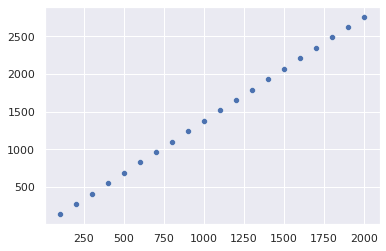

In [37]:
sns.scatterplot(x = list(range(100, 2100, 100)), y=sa_results)

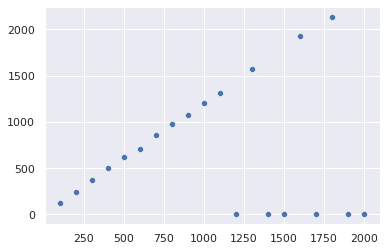

In [38]:
sns.scatterplot(x = list(range(100, 2100, 100)), y=gnn_results)

Now for d=5

In [39]:
d5_graphs = {
    i: nx.convert_node_labels_to_integers(nx.random_regular_graph(d=5, n=i, seed=2023)) for i in range(100, 2100, 100)
}

In [40]:
for i, G in tqdm(d5_graphs.items()):
  
  annealing_sol = solve_with_annealing(G, num_reads=2000)
  model = annealing_sol["model"]
  sa_results.append(-annealing_sol["energy"])

  print(f"N = {i}, Anneling found {sa_results[-1]}")

  embedding_d0 = int(np.sqrt(i))
  embedding_d1 = embedding_d0//2
  learning_rate = 0.005
  epochs = 10000
  if i < 1400:
    dropout_rate = 0.01
  else:
    dropout_rate = 0.05
  gnn_sol = solve_with_gnn(G, embedding_d0, embedding_d1, learning_rate, epochs, dropout_rate, seed=2023, verbose=False)


  gnn_results.append(
      -model.decode_sample(gnn_sol["solution"], vartype="BINARY").energy
  )
  print(f"N = {i}, Graph Neural Networks found {gnn_results[-1]}")

  0%|          | 0/20 [00:00<?, ?it/s]

N = 100, Anneling found 205.0
N = 100, Graph Neural Networks found 183.0
N = 200, Anneling found 411.0
N = 200, Graph Neural Networks found 368.0
N = 300, Anneling found 623.0
N = 300, Graph Neural Networks found 545.0
N = 400, Anneling found 829.0
N = 400, Graph Neural Networks found 730.0
N = 500, Anneling found 1039.0
N = 500, Graph Neural Networks found 919.0
N = 600, Anneling found 1244.0
N = 600, Graph Neural Networks found -0.0
N = 700, Anneling found 1455.0
N = 700, Graph Neural Networks found 1279.0
N = 800, Anneling found 1661.0
N = 800, Graph Neural Networks found 1486.0
N = 900, Anneling found 1871.0
N = 900, Graph Neural Networks found 1691.0
N = 1000, Anneling found 2080.0
N = 1000, Graph Neural Networks found 1836.0
N = 1100, Anneling found 2285.0
N = 1100, Graph Neural Networks found 2025.0
N = 1200, Anneling found 2492.0
N = 1200, Graph Neural Networks found -0.0
N = 1300, Anneling found 2709.0
N = 1300, Graph Neural Networks found 2419.0
N = 1400, Anneling found 2915.